In [124]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [125]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set num of classes

In [126]:
NUM_CLASSES = 26

# Read dataset

In [127]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [128]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Build model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'D),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [131]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,356 (5.30 KB)

 Trainable params: 1,356 (5.30 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [133]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model

In [134]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0391 - loss: 3.4030
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.0530 - loss: 3.3529 - val_accuracy: 0.0203 - val_loss: 3.3058
Epoch 2/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0625 - loss: 3.3700
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0510 - loss: 3.3505 - val_accuracy: 0.0439 - val_loss: 3.2835
Epoch 3/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0547 - loss: 3.2703
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0382 - loss: 3.2888 - val_accuracy: 0.0270 - val_loss: 3.2676
Epoch 4/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0391 - loss: 3.2876
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
7/7 ━━━━━━━━

In [135]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8527 - loss: 0.6893


In [136]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [137]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[1.8000254e-08 2.4041141e-05 1.7928675e-08 3.0420125e-02 3.8219769e-06
 2.9056759e-05 1.1691028e-08 1.5810802e-09 1.6648466e-08 2.2920284e-08
 8.5239716e-02 2.1491169e-05 4.1956635e-04 6.2500808e-04 1.1225355e-06
 4.1768294e-07 8.0964419e-08 2.8995199e-02 4.7364492e-07 2.0444139e-07
 7.8034237e-02 7.5066590e-01 1.8700866e-02 4.1406928e-03 8.0884277e-09
 2.6780039e-03]
21


# Confusion matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


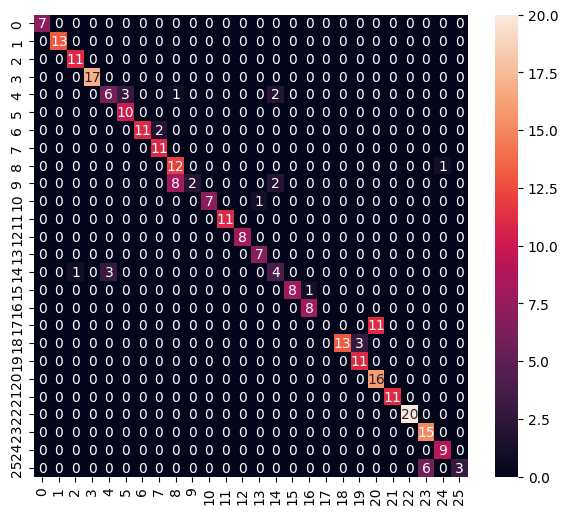

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13
           2       0.92      1.00      0.96        11
           3       1.00      1.00      1.00        17
           4       0.67      0.50      0.57        12
           5       0.77      1.00      0.87        10
           6       1.00      0.85      0.92        13
           7       0.85      1.00      0.92        11
           8       0.57      0.92      0.71        13
           9       1.00      0.17      0.29        12
          10       1.00      0.88      0.93         8
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00         8
          13       0.88      1.00      0.93         7
          14       0.50      0.50      0.50         8
          15       1.00      0.89      0.94         9
          16       0.89      1.00      0.94         8
     

c:\Users\endpl\anaconda3\envs\asl_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\endpl\anaconda3\envs\asl_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\endpl\anaconda3\envs\asl_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model (for Tensorflow-Lite)

In [139]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [140]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\endpl\AppData\Local\Temp\tmpr4w88owo\assets


INFO:tensorflow:Assets written to: C:\Users\endpl\AppData\Local\Temp\tmpr4w88owo\assets


Saved artifact at 'C:\Users\endpl\AppData\Local\Temp\tmpr4w88owo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2398341367584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398344765760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398344763824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398344766288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398344759600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398344975056: TensorSpec(shape=(), dtype=tf.resource, name=None)


7540

# Inference test

In [141]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Users\endpl\anaconda3\envs\asl_env\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [142]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [143]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [144]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4.95 ms


In [145]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.8000254e-08 2.4041163e-05 1.7928709e-08 3.0420113e-02 3.8219805e-06
 2.9056817e-05 1.1691026e-08 1.5810829e-09 1.6648499e-08 2.2920323e-08
 8.5239708e-02 2.1491169e-05 4.1956711e-04 6.2500889e-04 1.1225377e-06
 4.1768368e-07 8.0964419e-08 2.8995205e-02 4.7364585e-07 2.0444195e-07
 7.8034230e-02 7.5066590e-01 1.8700877e-02 4.1406923e-03 8.0884437e-09
 2.6780036e-03]
21
